In [8]:
import math as ma
import pandas_datareader as web 
import numpy as np 
import pandas as pd 
from sklearn.preprocessing import MinMaxScaler 
from keras.models import Sequential 
from keras.layers import Dense, LSTM
import datetime as dt
import matplotlib.pyplot as plt 

import ta
from ta import momentum
from ta.momentum import RSIIndicator


Empty DataFrame
Columns: []
Index: []


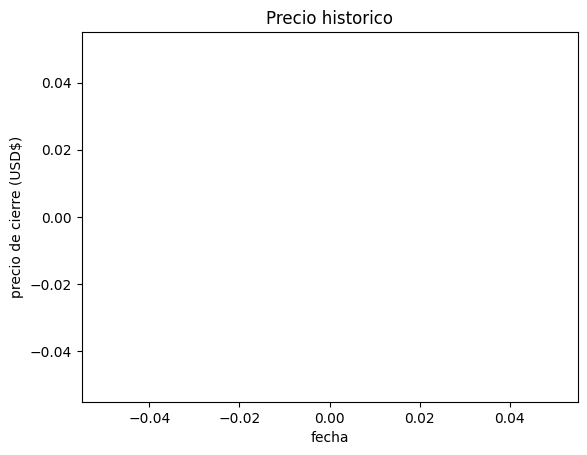

0


In [10]:
#var de testeo
stride = 5
simbolo = "SYP"
#conseguir la data
dfTrain = web.DataReader(simbolo, 'stooq', dt.datetime(2020,1,1), dt.datetime(2023,1,1))
dfTest = web.DataReader(simbolo, 'stooq', dt.datetime(2023,1,1), dt.date.today())


dataTrain = dfTrain.filter(['Close'])
#agrego indicadores: 
# dataTrain['RSI'] = ta.momentum.RSIIndicator(close=dataTrain['Close'], window=14).rsi()
# dataTrain['EMAF']=ta.ema(dataTrain['Close'], length=20)
# dataTrain['EMAM']=ta.ema(dataTrain['Close'], length=100)
# dataTrain['EMAS']=ta.ema(dataTrain['Close'], length=150)

print(dataTrain)
dataTest = dfTest.filter(['Close'])
#print(data)
plt.title('Precio historico')
plt.plot(dataTrain)
plt.xlabel("fecha")
plt.ylabel("precio de cierre (USD$)")
# plt.axis((2020,2023,ma.floor(min(dataTrain.values)), ma.ceil(max(dataTrain.values))))
plt.show()

print(len(dataTrain))

dataTrain =dataTrain.values 
dataTest = dataTest.values

dataTrain = np.flip(dataTrain)
dataTest = np.flip(dataTest)



In [229]:
#normalizar la data 
scaler = MinMaxScaler(feature_range=(0,1))
dataNormTrain = scaler.fit_transform(dataTrain)
dataNormTest = scaler.fit_transform(dataTest)

print(dataNormTrain)

[[0.24652427]
 [0.23683027]
 [0.23452489]
 [0.23867244]
 [0.23867244]
 [0.23914004]
 [0.23867244]
 [0.23821896]
 [0.24051508]
 [0.23590384]
 [0.23498275]
 [0.23452489]
 [0.23683027]
 [0.23452489]
 [0.23360381]
 [0.22714163]
 [0.2220584 ]
 [0.22575198]
 [0.22762775]
 [0.22669254]
 [0.22575198]
 [0.23325993]
 [0.24264852]
 [0.20181654]
 [0.19900021]
 [0.19242795]
 [0.19008457]
 [0.19196034]
 [0.19853212]
 [0.19900021]
 [0.19196034]
 [0.19008457]
 [0.18726873]
 [0.18867641]
 [0.18210415]
 [0.16708873]
 [0.15112836]
 [0.15018828]
 [0.13892441]
 [0.13845632]
 [0.14972019]
 [0.13892441]
 [0.1440885 ]
 [0.12812764]
 [0.11639616]
 [0.08870383]
 [0.10559502]
 [0.08870383]
 [0.06289214]
 [0.07603178]
 [0.04693177]
 [0.04693177]
 [0.02300023]
 [0.02159255]
 [0.01502029]
 [0.        ]
 [0.04411543]
 [0.06476791]
 [0.05820052]
 [0.0553798 ]
 [0.04787233]
 [0.03848374]
 [0.01830374]
 [0.01642797]
 [0.01079627]
 [0.02440353]
 [0.03285156]
 [0.04787233]
 [0.06383221]
 [0.05396676]
 [0.06007629]
 [0.04

In [230]:
#crear el dataset de entrenamiento 
#separar entre X e Y dataSets
#X son las entradas e Y es la salida esperada
x_train = []
y_train = []
for i in range(stride,len(dataNormTrain)):
    x_train.append(dataNormTrain[i-stride:i,0])
    y_train.append(dataNormTrain[i,0])
    # if i<=61: 
    #     print(x_train)
    #     print(y_train)



In [231]:
#hacerlos np.arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

#el modelo necesita el numero de samples, de datos y de features
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1] ,1))

In [232]:
#construir la red LSTM #!aprender que hace esto bien (o buscar el codigo pelado)
model = Sequential() 
model.add(LSTM(10,return_sequences=False, input_shape = (x_train.shape[1],1), activation= "linear"))
# model.add(LSTM(50, return_sequences=False))
model.add(Dense(1))


In [233]:
#compilar el modelo 
model.compile(optimizer= 'adam', loss= 'mean_squared_error') 


In [234]:
#train 
print(x_train.shape)
print(y_train.shape)
model.fit(x_train, y_train, batch_size= 1, epochs= 1)


(751, 5, 1)
(751,)
751/751 [==============================] - 2s 2ms/step - loss: 0.0079


In [235]:
#crea datos para test
#separa en X y en Y 
testData = np.concatenate((dataNormTrain[-stride:,:],dataNormTest)) 

print(testData.shape)
x_test = []
y_test = dataTest[:,:]

print(len(dataNormTest))

for i in range(stride, len(testData)): 
     x_test.append(testData[i-stride:i,0])
#X contiene los valores no contempleados en el train, e y contiene la salida esperada
x_test = np.array(x_test)
x_test = np.reshape(x_test,(x_test.shape[0], x_test.shape[1],1))
print(x_test.shape)
print(y_test.shape)


(229, 1)
224
(224, 5, 1)
(224, 1)


In [236]:
#prediccion del modelo para test
prediccion = model.predict(x_test)
prediccion = scaler.inverse_transform(prediccion)

7/7 [==============================] - 0s 1ms/step


In [237]:
#calcular error del modelo (RMSE)
#!chequear que el error este bien
rmse = np.sqrt(np.mean((prediccion - y_test)**2))
print(rmse)
prediccion = np.flip(prediccion)



0.45103609526733573


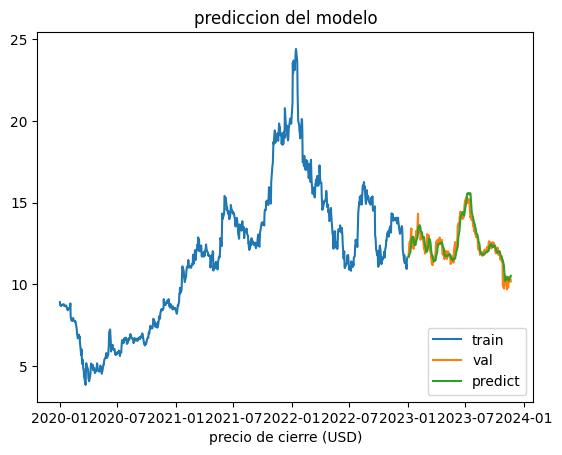

In [238]:
#grafica
train = dfTrain
valid = dfTest
valid['Predictions'] = prediccion
#plot
plt.title("prediccion del modelo")
plt.xlabel("modelo")
plt.xlabel("precio de cierre (USD)")
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['train', 'val', 'predict'], loc = 'lower right')
plt.show()


In [239]:
#imprimir los valores
print(valid)

             Open     High      Low  Close    Volume  Predictions
Date                                                             
2023-11-21  10.28  10.3200  10.1000  10.19  47195155    10.532140
2023-11-20  10.29  10.4300  10.2601  10.34  46996985    10.456881
2023-11-17  10.26  10.3199  10.1900  10.27  36611424    10.394954
2023-11-16  10.40  10.4300  10.1000  10.16  45408080    10.322861
2023-11-15  10.41  10.5700  10.3900  10.47  45193674    10.262960
...           ...      ...      ...    ...       ...          ...
2023-01-09  12.74  12.9300  12.5500  12.69  50865464    11.986322
2023-01-06  12.12  12.5900  12.1000  12.58  53089146    11.848327
2023-01-05  12.11  12.3800  11.8800  12.25  50785595    11.743163
2023-01-04  11.88  12.0800  11.7350  12.01  53429707    11.692784
2023-01-03  11.82  11.9200  11.5700  11.68  45809007    11.705708

[224 rows x 6 columns]
